In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cbook as cbook
import seaborn as sns
from IPython.display import Image
from IPython.core.display import HTML 
import numpy as np
sns.set_style("whitegrid")

/Users/kelseymarkey/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def prep_for_plotting(experiment_name, sim):
    replication_results = pd.read_csv('mse/results_'+experiment_name+'_10.csv', index_col=0, )
    replication_results.reset_index(inplace=True)
    replication_results['experiment'] = experiment_name
    replication_results = replication_results.rename(columns={"T_mse": "T", "S_mse": "S", "X_mse": "X", "n": "N"})
    replication_results = pd.melt(replication_results, id_vars=['experiment', 'simulation', 'N'],
                                  value_vars=['X', 'S', 'T'], 
                                  var_name='metalearner', 
                                  value_name='mse')
    replication_results = replication_results[replication_results['simulation']==sim]
    return replication_results

In [3]:
def prep_author_repo_for_plotting(sim):
    # initialize master df
    author_repo_results=pd.DataFrame()

    # set up dictionary that maps our sim names to author repo sim names
    sim_dict = {'simA':'unbalanced_treatment',
              'simB':'complex_linear',
              'simC': 'complex_nonlinear',
              'simD': 'beta_confounded'}
    # reach in each sim from author repo and concatenate so schema is the same as our results df
    for sim_letter, sim_description in sim_dict.items():
        url = 'https://raw.githubusercontent.com/theo-s/metalearners-reproduction/d3594c886f07480bc496bc91f60c5c62894d0c70/code/Appendix/results/'+sim_description+'EMSE.csv'
        df = pd.read_csv(url)

        # add our sim name
        df['simulation'] = sim_letter

        # drop BART columns since we did not use that base learner
        cols = [c for c in df.columns if c[1:] != 'BART']
        df = df[cols]

        # append each sim to master df
        author_repo_results = pd.concat([author_repo_results, df])
        author_repo_results['experiment'] = 'author_results'
    
    author_repo_results = author_repo_results.rename(columns={"TRF": "T", "SRF": "S", "XRF": "X"})
    author_repo_results = pd.melt(author_repo_results, id_vars=['experiment', 'simulation', 'N'],
                              value_vars=['X', 'S', 'T'], 
                              var_name='metalearner', 
                              value_name='mse')
    author_repo_results = author_repo_results[author_repo_results['simulation']==sim]
    return author_repo_results

In [39]:
def plot_replication_results(sim, analysis):
    '''
    sim: str, corresponding to sim in results table i.e. 'simA'
    analysis: either 'Replication', 'Tuning', or 'Base Learner'
    '''
    palette ={"X": "b", "S": "g", "T": "k"}
    experiments={1:'rf_g_rfc_default', 2:'rf_g_logreg_default', 
             3:'rf_g_rfc_authors', 4:'rf_g_rfc_tuned', 
             5:'iw_g_logreg_default', 6:'iw_g_rfc_default'}
    
    ylim_dict={'simA':(0.1, 100), 'simB':(1, 10000), 
             'simC':(0.001, 1), 'simD':(0.00005, 5), 
             'simE':(10**-4, 10**2), 'simF':(10**0, 10**2)}
    
    if analysis == 'Replication':
        fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
        fig.suptitle(sim+': '+analysis+' Analysis', 
                    fontsize='x-large', 
                    fontweight='heavy', 
                    x=0.2)
        axes[0].set_title('Author Results from Paper')
        axes[0].set_visible(False)
        
        sns.lineplot(ax=axes[1], data=prep_author_repo_for_plotting(sim),
                     x="N", y="mse", hue="metalearner", style="metalearner", markers= ["P","o", "^"], palette=palette)
        axes[1].set(xlim=(0, 300000))
        axes[1].set(ylim=ylim_dict[sim])
        axes[1].set_title('Author Results from Repo')
        axes[1].set_yscale('log')
        axes[1].set_xscale('linear')
        
        sns.lineplot(ax=axes[2], data=prep_for_plotting(experiments[3], sim),
                       x="N", y="mse", hue="metalearner", style="metalearner", markers= ["P","o", "^"], palette=palette)
        axes[2].set_title("Replicated Results using CausalToolbox Hyperparameters")
        axes[2].set(xlim=(0, 300000))
        axes[2].set_yscale('log')
        axes[2].set_xscale('linear')
        
        axes[0].tick_params("y", left=False, labelleft=False)
        axes[1].tick_params("y", left=True, labelleft=True)
    
    
    elif analysis == 'Tuning':
        fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
        fig.suptitle(sim+': '+analysis+' Analysis', 
                    fontsize='x-large', 
                    fontweight='heavy', 
                    x=0.2)

        sns.lineplot(ax=axes[0], data=prep_for_plotting(experiments[1], sim),
                     x="N", y="mse", hue="metalearner", style="metalearner", markers= ["P","o", "^"], palette=palette)
        axes[0].set_title("Results with Default Package Hyperparameters")
        axes[0].set(xlim=(0, 300000))
        axes[0].set_yscale('log')
        
        sns.lineplot(ax=axes[1], data=prep_for_plotting(experiments[3], sim),
                     x="N", y="mse", hue="metalearner", style="metalearner", markers= ["P","o", "^"], palette=palette)
        axes[1].set_title("Results with Hyperparameters from CausalToolbox")
        axes[1].set(xlim=(0, 300000))
        axes[1].set_yscale('log')

        sns.lineplot(ax=axes[2], data=prep_for_plotting(experiments[4], sim),
                     x="N", y="mse", hue="metalearner", style="metalearner", markers= ["P","o", "^"], palette=palette)
        axes[2].set_title("Results with Our Tuned Hyperparameters")
        axes[2].set(xlim=(0, 300000))
        axes[2].set_yscale('log')
    
    
    
    elif analysis == 'Base Learner':
        fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey=True)
        fig.suptitle(sim+': '+analysis+' Analysis', 
                    fontsize='x-large', 
                    fontweight='heavy', 
                    x=0.25)
        
        sns.lineplot(ax=axes[0,0], data=prep_for_plotting(experiments[5], sim),
                     x="N", y="mse", hue="metalearner", style="metalearner", markers= ["P","o", "^"], palette=palette)
        axes[0,0].set_title("LR-IW Results, Propensity Fit with LogReg")
        axes[0,0].set_yscale('log')

        sns.lineplot(ax=axes[0,1], data=prep_for_plotting(experiments[2], sim),
                     x="N", y="mse", hue="metalearner", style="metalearner", markers= ["P","o", "^"], palette=palette)
        axes[0,1].set_title("RF Results, Propensity Fit with LogReg")
        axes[0,1].set_yscale('log')

        sns.lineplot(ax=axes[1,0], data=prep_for_plotting(experiments[6], sim),
                     x="N", y="mse", hue="metalearner", style="metalearner", markers= ["P","o", "^"], palette=palette)
        axes[1,0].set_title("LR-IW Results, Propensity Fit with RFC")
        axes[1,0].set_yscale('log')
        
        sns.lineplot(ax=axes[1,1], data=prep_for_plotting(experiments[1], sim),
                     x="N", y="mse", hue="metalearner", style="metalearner", markers= ["P","o", "^"], palette=palette)
        axes[1,1].set_title("RF Results, Propensity Fit with RFC")
        axes[1,1].set_yscale('log')
    
    plt.show()
    return


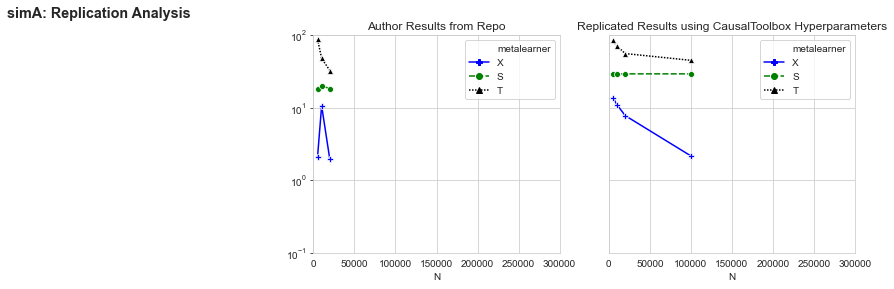

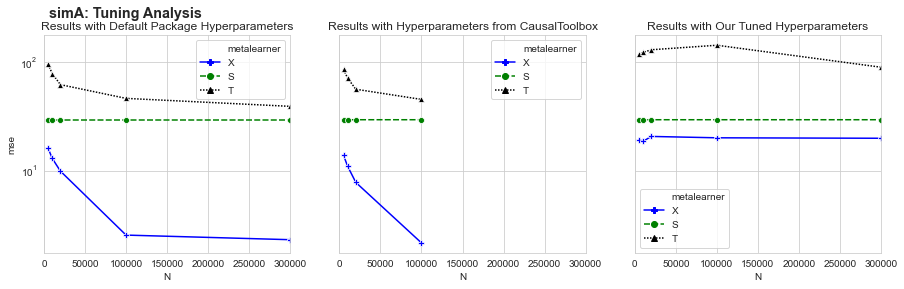

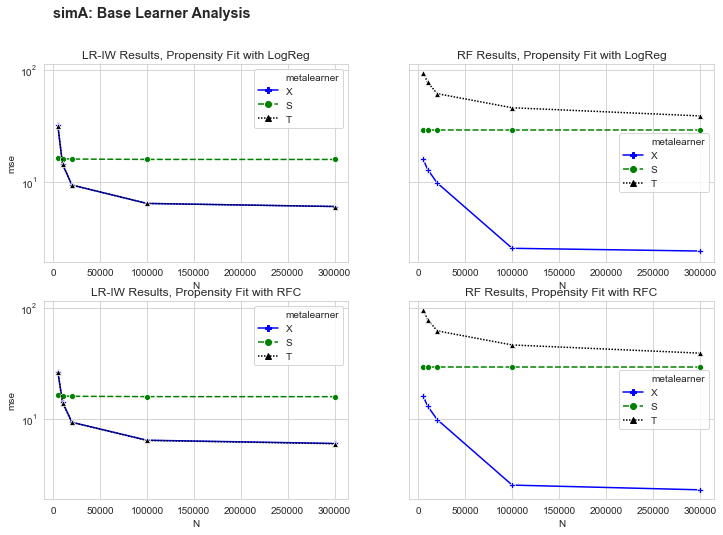

--------------------------------------------------------------------------------------------------------


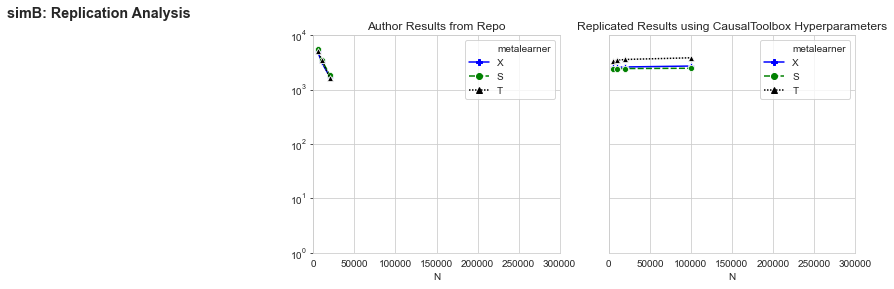

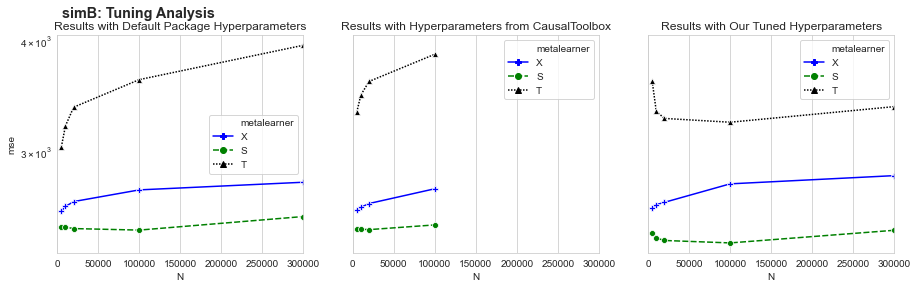

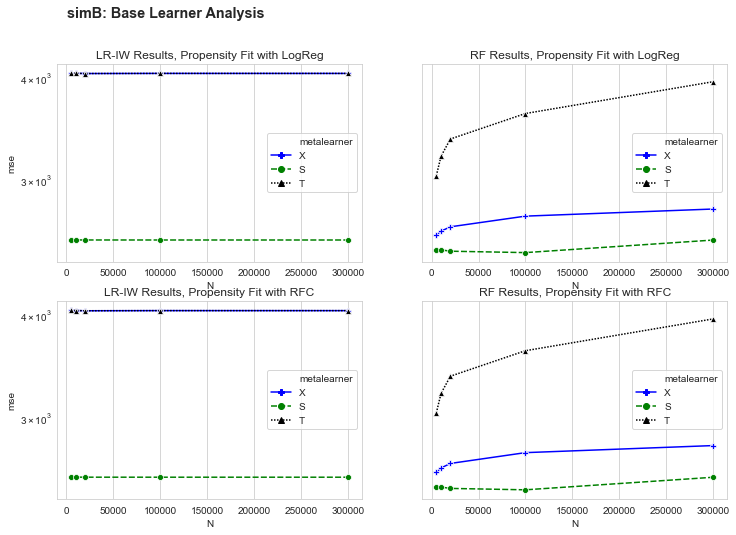

--------------------------------------------------------------------------------------------------------


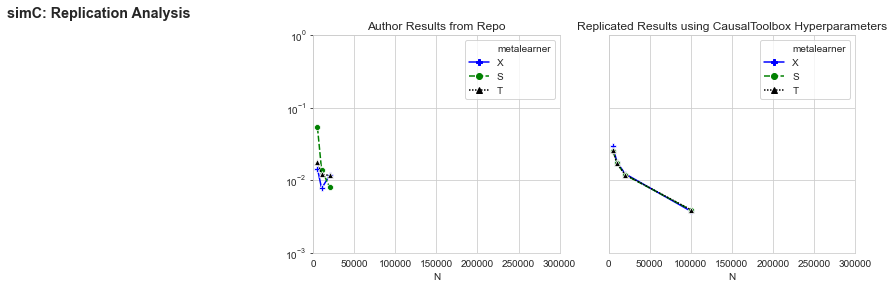

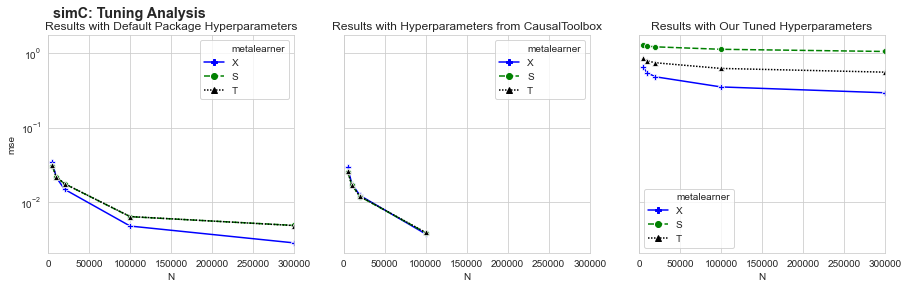

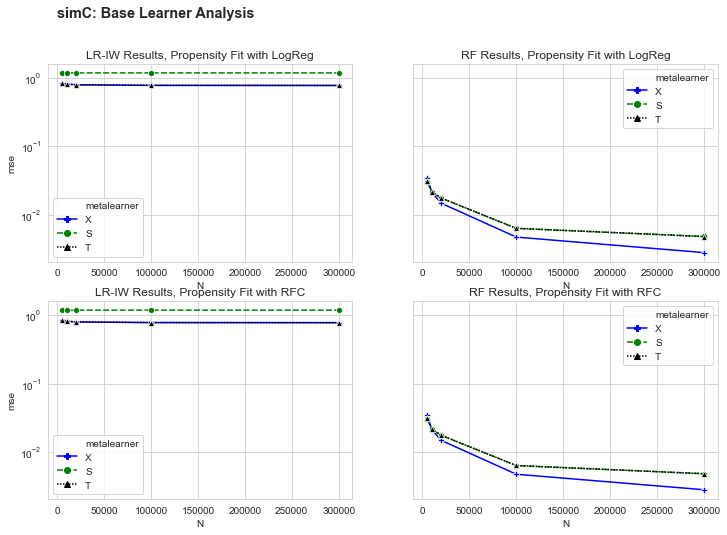

--------------------------------------------------------------------------------------------------------


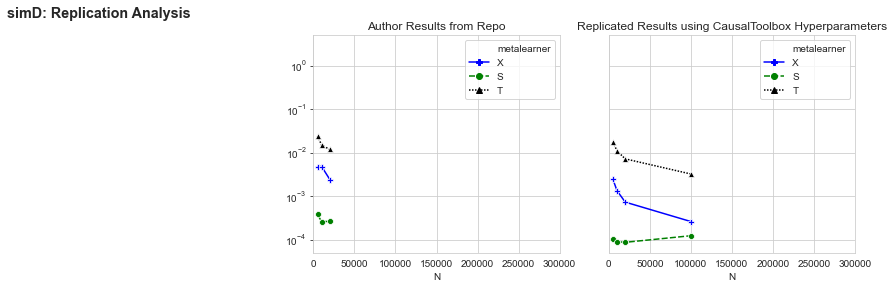

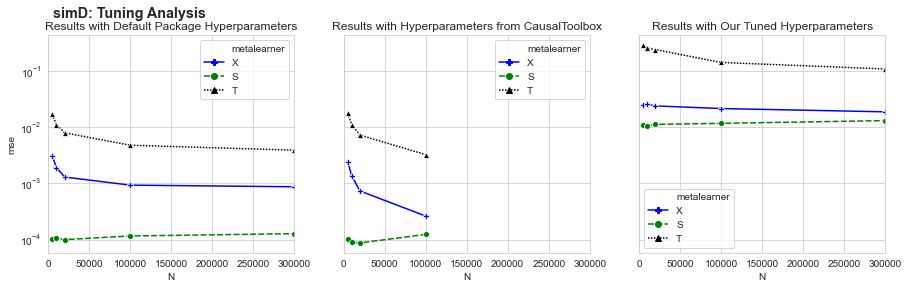

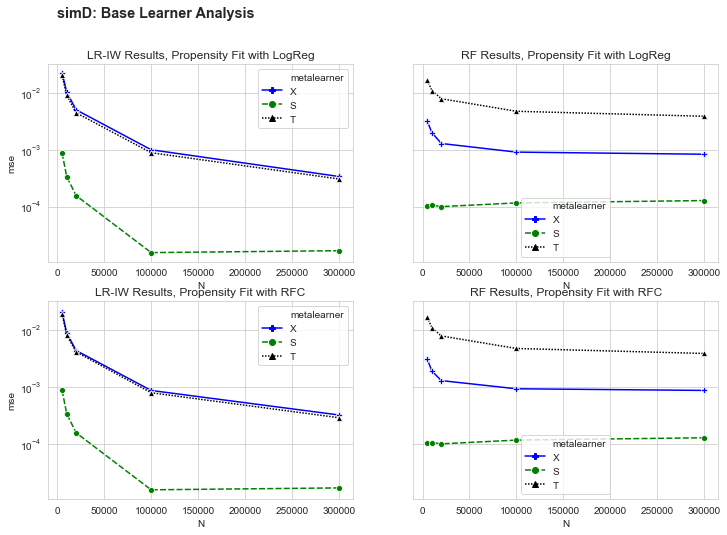

--------------------------------------------------------------------------------------------------------


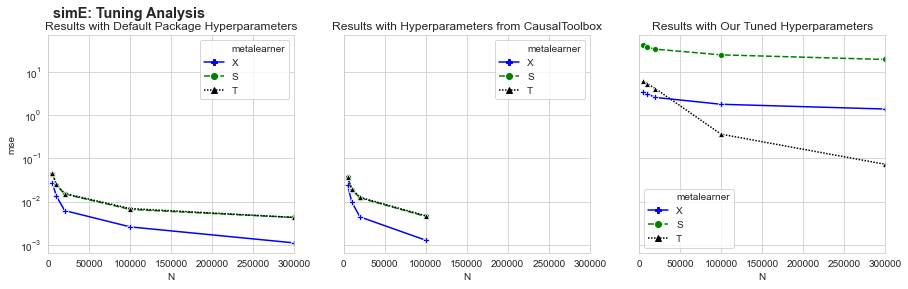

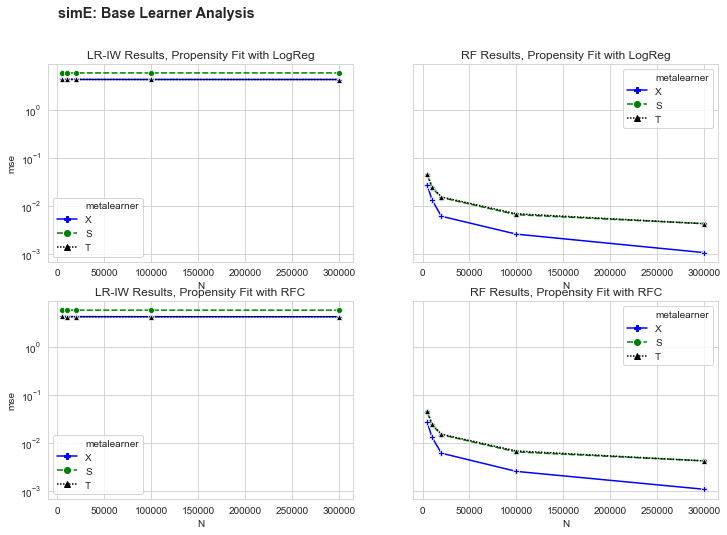

--------------------------------------------------------------------------------------------------------


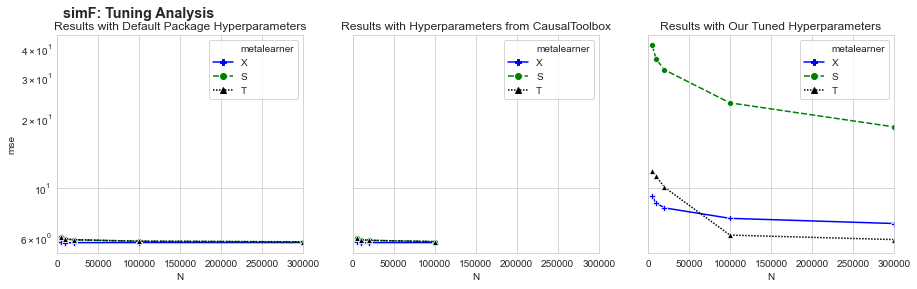

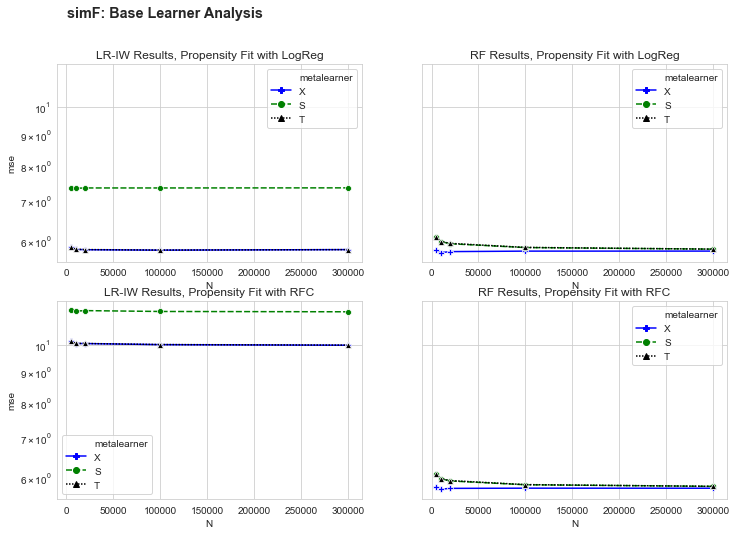

--------------------------------------------------------------------------------------------------------


In [40]:
for sim in ['simA', 'simB', 'simC', 'simD', 'simE', 'simF']:
    if sim in ['simA', 'simB', 'simC', 'simD']:
        plot_replication_results(sim, analysis='Replication')
    plot_replication_results(sim, analysis='Tuning')
    plot_replication_results(sim, analysis='Base Learner')
    print('--------------------------------------------------------------------------------------------------------')